In [1]:
using NonlinearSolve
using DifferentialEquations
using Plots
using Profile # Potentially useless. I tried to profile the solvers but they solve too fast (at least on my machine)
using ProfileSVG

## Using NonlinearSolve.jl to solve for steady state equilibria of prey-predator populations
Models of prey-predator systems are (mostly) expressed as nonlinear differential equations. That is, the population of a prey species (in these models) depends on it's own current population and its predator's current population  A central concept in analyzing these systems is the **steady state** (or **equilibrium**), a population configuration where the populations of prey and predator remain unchanging. Mathematically, these steady states are obtained by setting the time derivatives of the differential equations equal to zero. 

For classical prey-predator models like the Lotka-Volterra equations (which we will be initially using), the steady state often can't be found analytically. Thus, we must use rootfinding, which we can do with `NonlinearSolve.jl`.

### The Lotka-Volterra system
\begin{equation}
\begin{aligned}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= -\gamma y + \delta x y,
\end{aligned}
\end{equation}
where $\alpha, \beta, \gamma, \delta$ are all parameters relating to death/growth rates, and $x$ and $y$ represent the population density of prey and predators respectively.

In [2]:
function lvNonLinear(u, p) #returns the functions as a tuple, to be used with the NonlinearSolve
    x, y = u
    α, β, γ, δ = p
    
    return [
        α * x - β * x * y,
        -γ * y + δ * x * y
    ]
end

function lvODE!(du, u, p, t) #in place array modification to be used with DifferentialEquations
    x, y = u
    α, β, γ, δ = p
    
    du[1] = α * x - β * x * y
    du[2] = -γ * y + δ * x * y
end;

### Initial parameter test

In [3]:
u0 = [10, 10]
p = [1.1, 0.4, 0.4, 0.1]
tspan = (0.0,100.0); # Not relevant for NonlinearSolve

In [4]:
nonLinearProb = NonlinearProblem(lvNonLinear, u0, p)
nonLinearSol = solve(nonLinearProb, NewtonRaphson(); store_trace=Val(true))

retcode: Success
u: 2-element Vector{Float64}:
 4.0
 2.75

We successfully found the steady state of this prey-predator system with arbitrary initial parameters. \
We can graph the system now with assistance from the `DifferentialEquations.jl` package:

In [5]:
ODEProb = ODEProblem(lvODE!, u0, tspan, p)
ODESol = solve(ODEProb, Rodas5P());

Equilibrium: [4.0, 2.75]


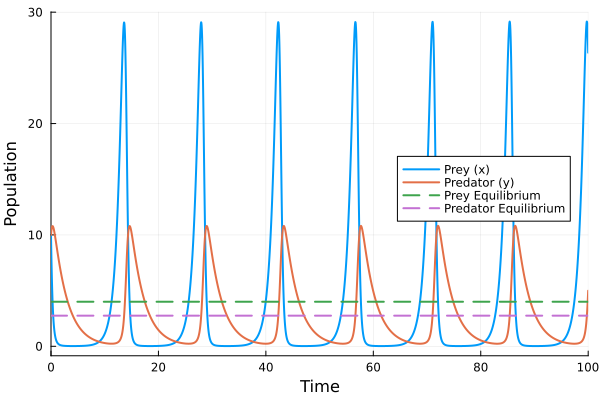

In [6]:
p1 = plot(ODESol, xlabel="Time", ylabel="Population", 
          label=["Prey (x)" "Predator (y)"],
          lw=2, legend=:right)
eq = nonLinearSol.u
println("Equilibrium: ", nonLinearSol.u)
hline!([eq[1]], label="Prey Equilibrium", linestyle=:dash, lw=2)
hline!([eq[2]], label="Predator Equilibrium", linestyle=:dash, lw=2)
plot(p1)

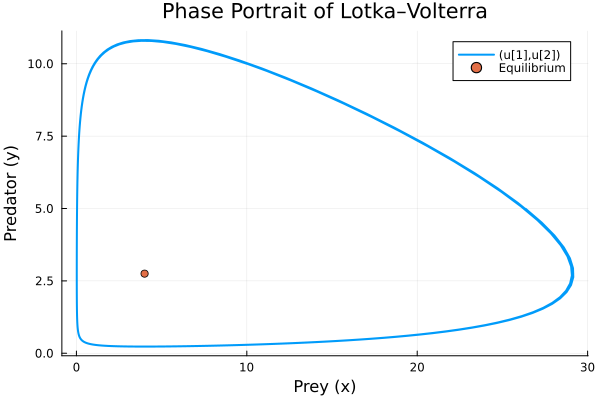

In [7]:
plot(ODESol, idxs=(1,2),
     xlabel="Prey (x)", ylabel="Predator (y)",
     title="Phase Portrait of Lotka–Volterra",
     lw=2)
scatter!([eq[1]], [eq[2]], label="Equilibrium", markersize=4)

Testing it out at the equilibrium:

Equilibrium: [4.0, 2.75]


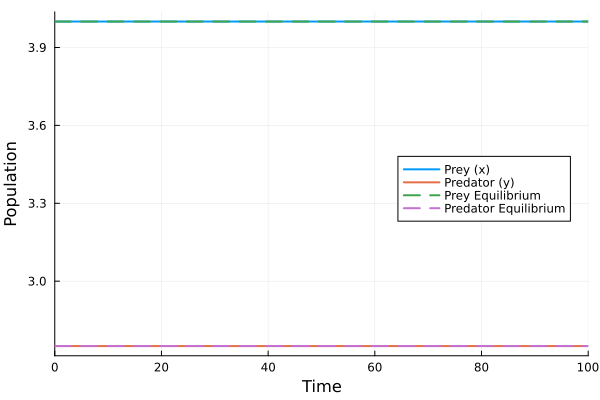

In [8]:
u0 = eq # eq is equilibrium from NonlinearSolve
p = [1.1, 0.4, 0.4, 0.1]
tspan = (0.0,100.0);
ODEProb = ODEProblem(lvODE!, u0, tspan, p)
ODESol = solve(ODEProb, Rodas5P());
p2 = plot(ODESol, xlabel="Time", ylabel="Population", 
          label=["Prey (x)" "Predator (y)"],
          lw=2, legend=:right)
eq = nonLinearSol.u
println("Equilibrium: ", nonLinearSol.u)
hline!([eq[1]], label="Prey Equilibrium", linestyle=:dash, lw=2)
hline!([eq[2]], label="Predator Equilibrium", linestyle=:dash, lw=2)
plot(p2)

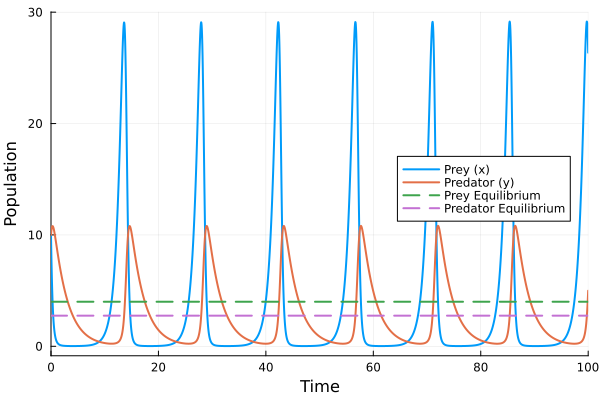

In [9]:
plot(p1) # For comparison. Presentation mode should have this plot and the image below side-by-side

![Image Test](./img/lotkavolterrareal.jpg)

### Parameter Sweeping and Reaching the limits

In [ ]:
u0_sweep = [10.0, 10.0]
tspan_sweep = (0.0, 100.0)

param_sweeps = [
    (1, LinRange(0.05, 5, 100), [nothing, 0.4, 0.4, 0.1], "alpha", "α", "Prey Growth Rate"),
    (2, LinRange(0.05, 5, 100), [1.0, nothing, 0.4, 0.1], "beta", "β", "Predation Rate"),
    (3, LinRange(0.05, 5, 100), [1.0, 0.4, nothing, 0.1], "gamma", "γ", "Predator Death Rate"),
    (4, LinRange(0.05, 5, 100), [1.0, 0.4, 0.4, nothing], "delta", "δ", "Predator Growth Rate")
]

for (param_idx, param_range, defaults, filename, symbol, description) in param_sweeps
    println("Sweeping $symbol")
    
    equilibria = []
    solutions = []
    
    for param_val in param_range
        p = copy(defaults)
        p[param_idx] = param_val
        
        nonLinearProb = NonlinearProblem(lvNonLinear, u0_sweep, p)
        nonLinearSol = solve(nonLinearProb, NewtonRaphson())
        push!(equilibria, nonLinearSol.u)
        
        ODEProb = ODEProblem(lvODE!, u0_sweep, tspan_sweep, p)
        ODESol = solve(ODEProb, Rodas5P())
        push!(solutions, ODESol)
    end
    
    anim_phase = @animate for (param_val, sol, eq) in zip(param_range, solutions, equilibria)
        plot(sol, idxs=(1,2),
             xlabel="Prey (x)", ylabel="Predator (y)",
             title="$description: $symbol = $(round(param_val, digits=3))",
             lw=2, legend=false,
             xlim=(0, 30), ylim=(0, 50))
        scatter!([eq[1]], [eq[2]], markersize=6, color=:red)
    end
    
    gif(anim_phase, "./img/phase_portrait_$filename.gif", fps=30)
    
    anim_ts = @animate for (param_val, sol, eq) in zip(param_range, solutions, equilibria)
        plot(sol, xlabel="Time", ylabel="Population",
             title="$description: $symbol = $(round(param_val, digits=3))",
             label=["Prey (x)" "Predator (y)"],
             lw=2, legend=:right,
             ylim=(0, 60))
        hline!([eq[1]], label="Prey Eq.", linestyle=:dash, lw=2, color=:blue, alpha=0.5)
        hline!([eq[2]], label="Predator Eq.", linestyle=:dash, lw=2, color=:red, alpha=0.5)
    end
    
    gif(anim_ts, "./img/time_series_$filename.gif", fps=30)
end

println("Done")

<div>
    <img src="./img/time_series_alpha.gif" width="400">
    <img src="./img/time_series_beta.gif" width="400">
    <img src="./img/time_series_gamma.gif" width="400">
    <img src="./img/time_series_delta.gif" width="400">
    <img src="./img/phase_portrait_alpha.gif" width="400">
    <img src="./img/phase_portrait_beta.gif" width="400">
    <img src="./img/phase_portrait_gamma.gif" width="400">
    <img src="./img/phase_portrait_delta.gif" width="400">
</div>

Note how our equilibrium moves as $\gamma$ increases. The non-trivial equilibrium moves significantly far away enough such that Newton's method starts solving for the trivial solution instead with our initial guess of $(10,10)$!

In [15]:
u0_lv = [10, 10]
p_lv = [1.1, 0.4, 0.4, 0.1]

solvers = [
    NewtonRaphson(),
    DFSane(),
    TrustRegion(),
    Broyden(),
]

names = ["NewtonRaphson", "DFSane", "TrustRegion", "Broyden"]

for (name, solver) in zip(names, solvers)
    println("\n Solver: ", name)
    prob = NonlinearProblem(lvNonLinear, u0_lv, p_lv)
    @time sol = solve(prob, solver; store_trace=Val(true))
    # @profview solve(prob, solver; store_trace=Val(true)) # Solve is too fast for profiler to take any samples

    println("Converged: ", sol.retcode == ReturnCode.Success)
    println("Iterations: ", length(sol.trace.history))
    println("Solution: ", sol.u)
end


 Solver: NewtonRaphson
  0.000060 seconds (140 allocations: 8.031 KiB)
Converged: true
Iterations: 8
Solution: [4.0, 2.75]

 Solver: DFSane
  0.000026 seconds (172 allocations: 9.297 KiB)
Converged: true
Iterations: 15
Solution: [-9.98572435474015e-20, 1.9743551024849887e-22]

 Solver: TrustRegion
  0.000052 seconds (162 allocations: 9.844 KiB)
Converged: true
Iterations: 8
Solution: [4.0000000000000036, 2.7500000000000027]

 Solver: Broyden
  0.000042 seconds (211 allocations: 9.766 KiB)
Converged: true
Iterations: 27
Solution: [1.1021641268483635e-14, 2.548085258388534e-14]


## Model 2: Holling Type II Functional Response

The Lotka-Volterra model assumes the predator's consumption rate increases linearly with prey density (unlimited appetite). The **Holling Type II** model introduces **saturation**: predators take time to handle prey, so consumption levels off at high prey densities.

The equations are:
$$
\begin{aligned}
\frac{dx}{dt} &= \alpha x - \frac{\beta x y}{1 + h x} \\
\frac{dy}{dt} &= -\gamma y + \frac{\delta x y}{1 + h x}
\end{aligned}
$$

Where $h$ is the handling time. This nonlinearity can lead to more complex dynamics, such as limit cycles or stable equilibria, and makes finding the equilibrium point more challenging for solvers.

In [36]:
function lv_holling2NonLinear(u,p)
    x,y = u
    α, β, γ, δ, h = p
    denom = 1 + h*x
    return [
        α*x - β*x*y/denom,
        -γ*y + δ*x*y/denom
    ]
end

function lv_holling2!(du,u,p,t)
    x,y = u
    α, β, γ, δ, h = p
    denom = 1 + h*x
    du[1] = α*x - β*x*y/denom
    du[2] = -γ*y + δ*x*y/denom
end

lv_holling2! (generic function with 1 method)

In [37]:
# Parameters for Holling Type II solver comparison
u0_h2 = [2.0, 1.5]
p_h2 = [0.4, 0.4, 0.2, 0.5, 0.05]  # α, β, γ, δ, h - stable parameter set
tspan_h2 = (0.0, 200.0)

(0.0, 200.0)

### Solver Comparison for Holling Type II
We repeat the solver comparison for the Holling Type II model. Again, observe if any solvers fail to find the non-trivial equilibrium.

In [39]:
for (name, solver) in zip(names, solvers)
    println("\n Solver: ", name)
    prob = NonlinearProblem(lv_holling2NonLinear, u0_h2, p_h2)
    @time sol = solve(prob, solver; store_trace=Val(true))

    println("Converged: ", sol.retcode == ReturnCode.Success)
    println("Iterations: ", length(sol.trace.history))
    println("Solution: ", sol.u)
end


 Solver: NewtonRaphson
  0.000061 seconds (124 allocations: 7.344 KiB)
Converged: true
Iterations: 7
Solution: [0.40816326530612246, 1.0204081632653061]

 Solver: DFSane
  0.000020 seconds (216 allocations: 10.969 KiB)
Converged: true
Iterations: 20
Solution: [-6.462348535570529e-27, -2.0618902985020414e-19]

 Solver: TrustRegion
  0.000046 seconds (183 allocations: 11.094 KiB)
Converged: true
Iterations: 11
Solution: [0.4081632653061225, 1.0204081632653061]

 Solver: Broyden
  0.000036 seconds (114 allocations: 6.203 KiB)
Converged: true
Iterations: 12
Solution: [1.0256003147965989e-14, 2.6671731976153018e-14]


### Holling-II Dynamics and Phase Portrait
This section computes the equilibrium and ODE solution for the Holling-II predator–prey model and then produces the time-series dynamics and the phase portrait with the equilibrium marked.

In [40]:
# Holling-II: equilibrium and ODE solution

nonLinearProb_h2 = NonlinearProblem(lv_holling2NonLinear, u0_h2, p_h2)
nonLinearSol_h2 = solve(nonLinearProb_h2, NewtonRaphson())
eq_h2 = nonLinearSol_h2.u
println("Holling-II Equilibrium found: ", eq_h2)

ODEProb_h2 = ODEProblem(lv_holling2!, u0_h2, tspan_h2, p_h2);
ODESol_h2 = solve(ODEProb_h2, Tsit5());

Holling-II Equilibrium found: [0.40816326530612246, 1.0204081632653061]


Holling-II Equilibrium: [0.40816326530612246, 1.0204081632653061]


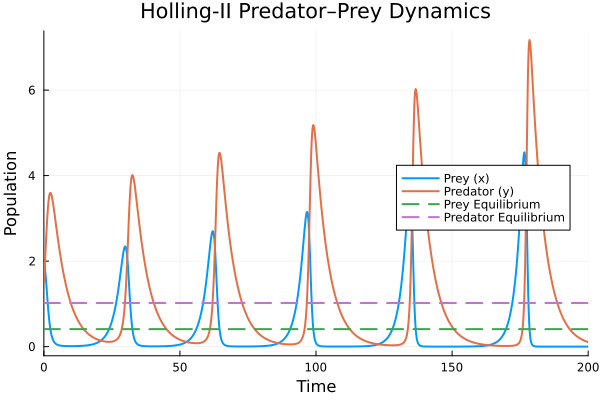

In [41]:
# Holling-II dynamics over time
p_h2_time = plot(ODESol_h2,
    xlabel="Time", ylabel="Population",
    title="Holling-II Predator–Prey Dynamics",
    label=["Prey (x)" "Predator (y)"],
    lw=2, legend=:right)
println("Holling-II Equilibrium: ", eq_h2)
hline!([eq_h2[1]], label="Prey Equilibrium", linestyle=:dash, lw=2)
hline!([eq_h2[2]], label="Predator Equilibrium", linestyle=:dash, lw=2)
plot(p_h2_time)

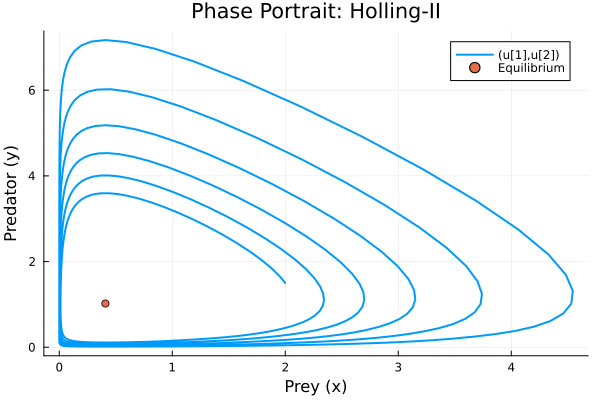

In [42]:
# Holling-II phase portrait
plot(ODESol_h2, idxs=(1,2),
     xlabel="Prey (x)", ylabel="Predator (y)",
     title="Phase Portrait: Holling-II",
     lw=2)
scatter!([eq_h2[1]], [eq_h2[2]], label="Equilibrium", markersize=4)

In [ ]:
u0_sweep = [2.0, 1.5]
tspan_sweep = (0.0, 100.0)

param_sweeps = [
    (1, LinRange(0.05, 1, 100), [nothing, 0.4, 0.2, 0.5, 0.05], "alpha2", "α", "Prey Growth Rate"),
    (2, LinRange(0.05, 1, 100), [0.4, nothing, 0.2, 0.5, 0.05], "beta2", "β", "Predation Rate"),
    (3, LinRange(0.05, 1, 100), [0.4, 0.4, nothing, 0.5, 0.05], "gamma2", "γ", "Predator Death Rate"),
    (4, LinRange(0.05, 1, 100), [0.4, 0.4, 0.2, nothing, 0.05], "delta2", "δ", "Predator Growth Rate"),
    (5, LinRange(0.005, 0.5, 100), [0.4, 0.4, 0.2, 0.5, nothing], "h", "h", "Handling Time")
]

for (param_idx, param_range, defaults, filename, symbol, description) in param_sweeps
    println("Sweeping $symbol")
    
    equilibria = []
    solutions = []
    
    for param_val in param_range
        p = copy(defaults)
        p[param_idx] = param_val
        
        nonLinearProb = NonlinearProblem(lv_holling2NonLinear, u0_sweep, p)
        nonLinearSol = solve(nonLinearProb, NewtonRaphson())
        push!(equilibria, nonLinearSol.u)
        
        ODEProb = ODEProblem(lv_holling2!, u0_sweep, tspan_sweep, p)
        ODESol = solve(ODEProb, Rodas5P())
        push!(solutions, ODESol)
    end
    
    anim_phase = @animate for (param_val, sol, eq) in zip(param_range, solutions, equilibria)
        plot(sol, idxs=(1,2),
             xlabel="Prey (x)", ylabel="Predator (y)",
             title="$description: $symbol = $(round(param_val, digits=3))",
             lw=2, legend=false,
             xlim=(0, 30), ylim=(0, 50))
        scatter!([eq[1]], [eq[2]], markersize=6, color=:red)
    end
    
    gif(anim_phase, "./img/phase_portrait_$filename.gif", fps=30)
    
    anim_ts = @animate for (param_val, sol, eq) in zip(param_range, solutions, equilibria)
        plot(sol, xlabel="Time", ylabel="Population",
             title="$description: $symbol = $(round(param_val, digits=3))",
             label=["Prey (x)" "Predator (y)"],
             lw=2, legend=:right,
             ylim=(0, 60))
        hline!([eq[1]], label="Prey Eq.", linestyle=:dash, lw=2, color=:blue, alpha=0.5)
        hline!([eq[2]], label="Predator Eq.", linestyle=:dash, lw=2, color=:red, alpha=0.5)
    end
    
    gif(anim_ts, "./img/time_series_$filename.gif", fps=30)
end

println("Done")

<div>
    <img src="./img/time_series_alpha2.gif" width="400">
    <img src="./img/time_series_beta2.gif" width="400">
    <img src="./img/time_series_gamma2.gif" width="400">
    <img src="./img/time_series_delta2.gif" width="400">
    <img src="./img/time_series_h.gif" width="400">
    <img src="./img/phase_portrait_h.gif" width="400">
    <img src="./img/phase_portrait_alpha2.gif" width="400">
    <img src="./img/phase_portrait_beta2.gif" width="400">
    <img src="./img/phase_portrait_gamma2.gif" width="400">
    <img src="./img/phase_portrait_delta2.gif" width="400">
</div>

### Why Nonlinear Solver Choice Matters

Both of our models (Lotka–Volterra and Holling-II) have **multiple equilibria**:
- A trivial extinction equilibrium $(x, y) = (0, 0)$
- A non-trivial coexistence equilibrium $(x^*, y^*)$ where both species survive

From the point of view of `NonlinearSolve.jl`, *both* are just roots of $F(u) = 0$. The solver doesn’t know which one we want; it simply follows its algorithm starting from our initial guess.

In our experiments:
- `NewtonRaphson` and `TrustRegion` usually converged to the coexistence equilibrium from our chosen starting point.
- `DFSane` and `Broyden` sometimes converged to the **trivial root** $(0,0)$ or failed to converge, even though a biologically meaningful root exists.

This shows that for nonlinear systems, **getting “a root” is not enough** – we have to think about which equilibrium is being selected and how the algorithm behaves near different roots.

### Numerical Takeaways

- Nonlinear solvers are **local**: they converge to whichever root is in the basin of attraction of the starting guess.
- Methods that use Jacobians (`NewtonRaphson`, `TrustRegion`) behaved well near the coexistence equilibrium, giving fast, reliable convergence.
- Derivative-free / quasi-Newton methods (`DFSane`, `Broyden`) were more sensitive to the initial guess and often preferred the trivial root.